In [1]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
%run dataloader.ipynb

train size:  7614
dev size:  980
test size:  994


In [3]:
batch_size=500
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

In [4]:
gpu_id = 'cuda:1'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [5]:
# cnn+rnn
class CNN_RNN(torch.nn.Module):

    def __init__(self, hidden_layer_size_1, window_size_1, hidden_layer_size_2) -> None:
        super().__init__()
        self.window_size_1 = window_size_1
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_1, 300, window_size_1)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((hidden_layer_size_1,), dtype=torch.float32))
        self.rnn1_s0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_2,)), dtype=torch.float32))
        self.rnn1_c0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_2,)), dtype=torch.float32))
        self.rnn2_s0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_2,)), dtype=torch.float32))
        self.rnn2_c0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_2,)), dtype=torch.float32))
        self.rnn = torch.nn.LSTM(hidden_layer_size_1, hidden_layer_size_2, batch_first=True, num_layers=2)
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_2, 1)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x, text_lens):
        x_t = x.transpose(1, 2)
        hidden_1_t = torch.nn.functional.leaky_relu(torch.nn.functional.conv1d(x_t, self.w1, self.b1))
        hidden_1 = hidden_1_t.transpose(1, 2)

        batch_size = hidden_1.shape[0]
        
        s0 = torch.stack((
            self.rnn1_s0,
            self.rnn2_s0,
        ), dim=0)
        s0 = s0.unsqueeze(1).tile((1, batch_size, 1))

        c0 = torch.stack((
            self.rnn1_c0,
            self.rnn2_c0,
        ), dim=0)
        c0 = c0.unsqueeze(1).tile((1, batch_size, 1))

        (interm_states, (_, _)) = self.rnn(hidden_1, (s0, c0))
        hidden_2 = interm_states[torch.arange(batch_size), text_lens - self.window_size_1, :]

        return hidden_2@self.w2 + self.b2

step error


/tmp/ipykernel_2593113/324524730.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2593113/324524730.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2593113/324524730.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

1 0.8885009288787842
dev accuracy: 55.31%
2 0.6308746337890625
dev accuracy: 56.04%
3 0.6306856870651245
dev accuracy: 59.75%
4 0.5595582723617554
dev accuracy: 58.93%
5 0.5290197730064392
dev accuracy: 59.24%
6 0.4768161475658417
dev accuracy: 59.24%
7 0.4195394814014435
dev accuracy: 60.37%
8 0.3932267725467682
dev accuracy: 59.24%
9 0.32347843050956726
dev accuracy: 58.72%
10 0.22237960994243622
dev accuracy: 59.03%
11 0.21190112829208374
dev accuracy: 58.82%
12 0.16462069749832153
dev accuracy: 57.28%
13 0.0707748755812645
dev accuracy: 57.38%
14 0.06567663699388504
dev accuracy: 58.10%
15 0.08821272850036621
dev accuracy: 57.07%
16 0.04141668975353241
dev accuracy: 58.51%
17 0.05914543941617012
dev accuracy: 56.66%
18 0.025087319314479828
dev accuracy: 57.79%
19 0.014385119080543518
dev accuracy: 57.59%
20 0.013959744945168495
dev accuracy: 57.07%


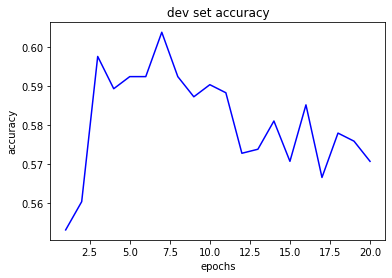

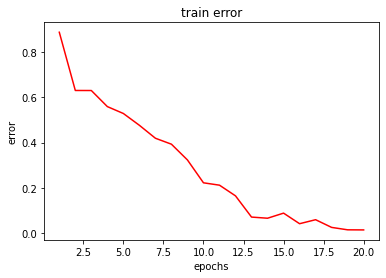

In [12]:
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
cnn_rnn = CNN_RNN(hidden_layer_size_1=512, window_size_1=2, hidden_layer_size_2=512)
cnn_rnn.to(device)

optimiser = torch.optim.Adam(cnn_rnn.parameters(), lr=0.0001)
epochs = 20

print('step', 'error')
dev_accs = []
errors = []
for epoch in range(1, epochs+1):
    for batch_idx, batch in enumerate(train_dataloader, 0):
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        optimiser.zero_grad()
        output = cnn_rnn(x_p[:, :, :300], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0): 
            x_p,x_c,y,hid, x_p_len=map(lambda x: x.to(device), batch)
            outputs = torch.sigmoid(cnn_rnn(x_p[:, :, :300], x_p_len))
            predictions = (outputs > 0.5)*1
            matches += (y == predictions).sum()
            total += len(y)
        acc = matches / total
        dev_accs.append(float(acc))
        print('dev accuracy: {:.2%}'.format(float(acc)))

plt.plot(range(1, epochs+1), dev_accs, 'b')
plt.title('dev set accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(range(1, epochs+1), errors, 'r')
plt.title('train error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.show()

In [13]:
with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid, x_p_len=map(lambda x: x.to(device), batch)
        outputs = torch.sigmoid(cnn_rnn(x_p[:, :, :300], x_p_len))
        predictions = (outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
    acc = matches / total
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_2593113/324524730.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2593113/324524730.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2593113/324524730.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

test accuracy: 58.57%
